# 1. EE4740 Project: Image Compression

Group Members: Hongyu Zhou | Yuhan Xu 
We implemented different methods (BIHT, FNN, VAE) to solve this problem. We compared their performance

In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from ProcessData import *
from Calculation import *
from BIHT import *
from Visualization import *
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import random
import pickle

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed) 
    torch.cuda.manual_seed_all(seed) 
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Load the data

In [2]:

train_file = 'mnist_train.csv'
test_file = 'mnist_test.csv'

with open(train_file, 'r') as f:
    train_data_reader = csv.reader(f)
    train_data = list(train_data_reader)
    train_data_array = np.array(train_data, dtype=float)
    
with open(test_file, 'r') as f:
    test_data_reader = csv.reader(f)
    test_data = list(test_data_reader)
    test_data_array = np.array(test_data, dtype=float) 

print(f'Size of Training Set: {np.shape(train_data_array)}')
print(f'Size of Testing Set: {np.shape(test_data_array)}')

# split labels
y_train = train_data_array[:, 0]
X_train = train_data_array[:, 1:]

y_test = test_data_array[:, 0]
X_test = test_data_array[:, 1:]

X_train_DL = X_train
X_test_DL = X_test
X_train_DL = X_train / 255 
X_test_DL = X_test / 255

# normalization
for i in range(X_train.shape[0]):
    norm = np.linalg.norm(X_train[i])
    if norm > 0:
        X_train[i] = X_train[i] / norm

for i in range(X_test.shape[0]):
    norm = np.linalg.norm(X_test[i])
    if norm > 0:
        X_test[i] = X_test[i] / norm



Size of Training Set: (60000, 785)
Size of Testing Set: (10000, 785)


# 1.0 Take look at the images and sparsity levels

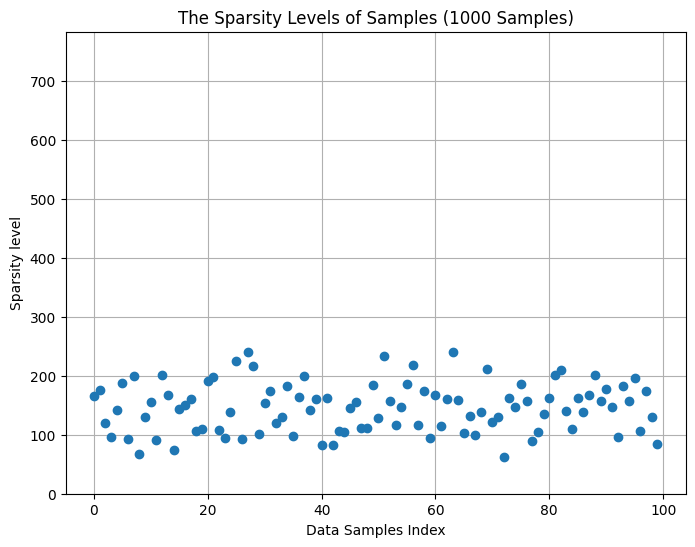

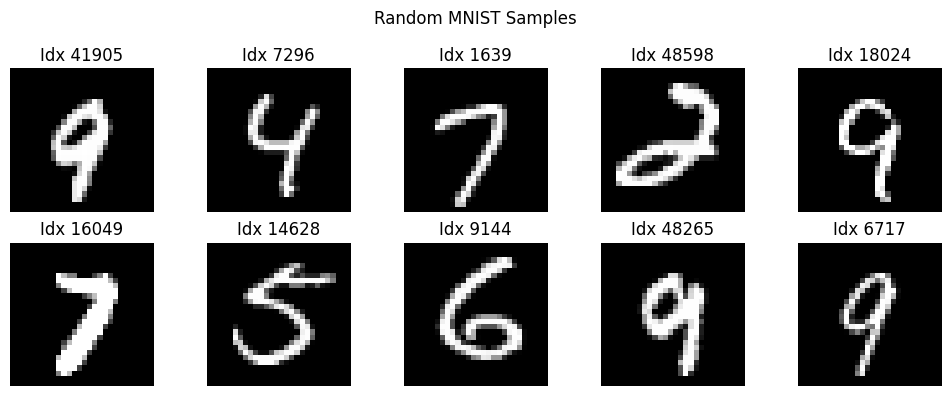

In [3]:
set_seed(42)
sparsity_list = []
for i in range(100):
    sparsity = Calculate_Sparse(X_train[i])
    sparsity_list.append(sparsity)

plt.figure(figsize=(8, 6))
plt.plot(sparsity_list, 'o')
plt.ylabel('Sparsity level')
plt.xlabel('Data Samples Index')
plt.ylim([0, 784])
plt.grid(True)
plt.title('The Sparsity Levels of Samples (1000 Samples)')
plt.show()

random_indices = random.sample(range(len(X_train)), 10)
plt.figure(figsize=(10, 4))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[idx].reshape([28, 28]), cmap='gray')
    plt.axis('off')
    plt.title(f'Idx {idx}')
plt.suptitle('Random MNIST Samples')
plt.tight_layout()
plt.show()

## 1.1 Generate Matrix A

In [4]:
set_seed(42)
Matrix_A_25_784 = Generate_Standard_Matrix_A(25, 784)
Matrix_A_100_784 = Generate_Standard_Matrix_A(100, 784)
Matrix_A_200_784 = Generate_Standard_Matrix_A(200, 784)
Matrix_A_500_784 = Generate_Standard_Matrix_A(500, 784)

## 1.2 Apply Sign Function
test one one image first

In [5]:
# test one sample
x_true = X_train[100]
y_25_784 = np.sign(Matrix_A_25_784 @ x_true)     # (25, )
y_100_784 = np.sign(Matrix_A_100_784 @ x_true)
y_200_784 = np.sign(Matrix_A_200_784 @ x_true)
y_500_784 = np.sign(Matrix_A_500_784 @ x_true)



# 1.3 See the recovery of the selected image
Try BIHT on one image

0.682104388237117
[-0.06495395  0.         -0.          0.          0.         -0.
 -0.10911467 -0.          0.         -0.          0.         -0.
 -0.          0.         -0.          0.          0.         -0.
 -0.          0.          0.          0.          0.         -0.
 -0.05391517 -0.         -0.         -0.          0.         -0.
 -0.          0.07665348  0.         -0.          0.          0.08936549
 -0.          0.         -0.          0.          0.          0.
  0.03240421 -0.          0.          0.         -0.         -0.
  0.          0.          0.          0.          0.         -0.
  0.         -0.         -0.          0.         -0.          0.
  0.         -0.         -0.          0.          0.         -0.09632333
 -0.          0.          0.         -0.          0.          0.
 -0.         -0.          0.          0.          0.         -0.
 -0.         -0.12986657 -0.         -0.          0.          0.
  0.          0.06229097  0.          0.          0.    

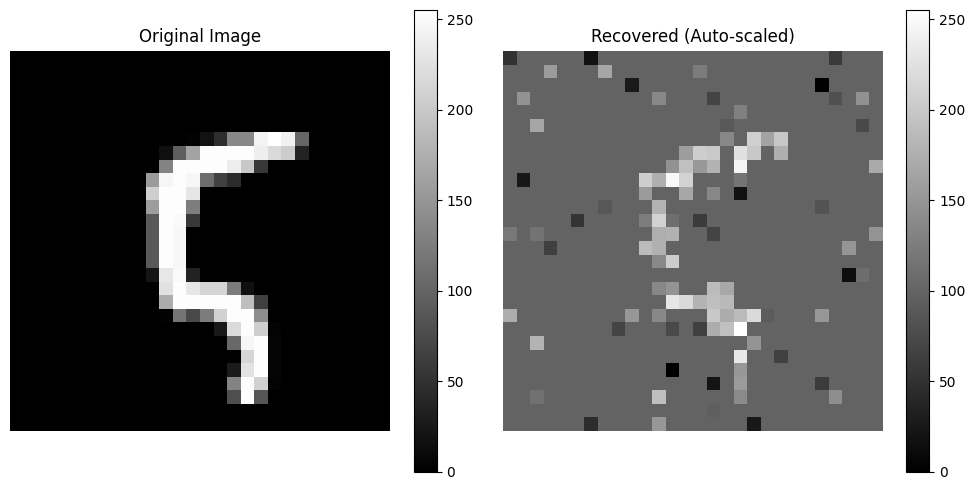

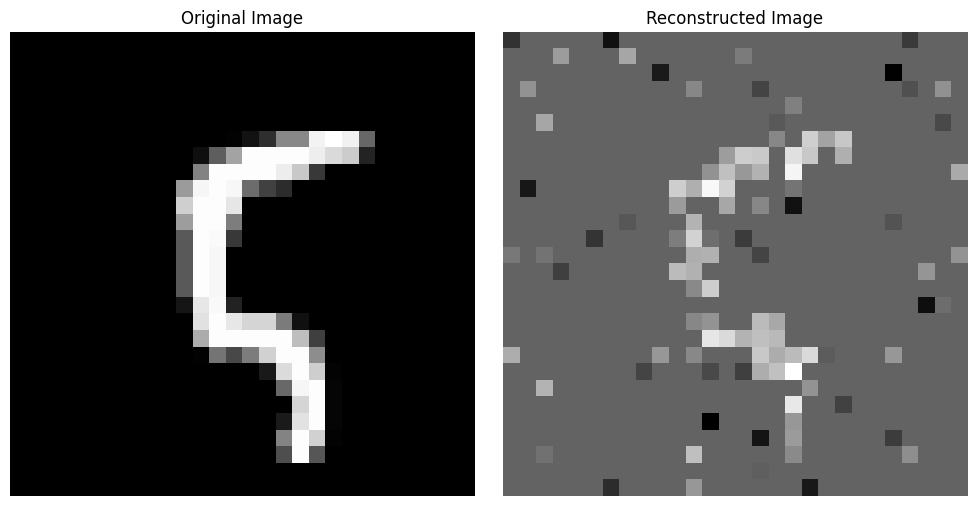

In [6]:
set_seed(42)
x_recovered = biht(Matrix_A_500_784, y_500_784, Calculate_Sparse(x_true), max_iter=20000)
mse, nmse = compute_metrics(x_true, x_recovered)
print(nmse)
print(x_recovered)
display_recovered_image_color(x_recovered, x_true)
display_recovered_image(x_recovered, x_true)


# 2. Start to use different methods

In this section, we will use BIHT, FNN and VAE

## 2.0 Generate A Matrix


In [7]:
set_seed(42)
measurements = [25, 100, 200, 500, 800, 1000, 1500, 2000]


A_dict = {
    '25': Generate_Standard_Matrix_A(25, 784),
    '100': Generate_Standard_Matrix_A(100, 784),
    '200': Generate_Standard_Matrix_A(200, 784),
    '500': Generate_Standard_Matrix_A(500, 784),
    '800': Generate_Standard_Matrix_A(800, 784),
    '1000': Generate_Standard_Matrix_A(1000, 784),
    '1500': Generate_Standard_Matrix_A(1500, 784),
    '2000': Generate_Standard_Matrix_A(2000, 784)
}

# For test data
y_test_dict = {
    '25': np.sign(A_dict['25'] @ X_test.T),
    '100': np.sign(A_dict['100'] @ X_test.T),
    '200': np.sign(A_dict['200'] @ X_test.T),
    '500': np.sign(A_dict['500'] @ X_test.T),
    '800': np.sign(A_dict['800'] @ X_test.T),
    '1000': np.sign(A_dict['1000'] @ X_test.T),
    '1500': np.sign(A_dict['1500'] @ X_test.T),
    '2000': np.sign(A_dict['2000'] @ X_test.T)
}

# For training data
y_train_dict = {
    '25': np.sign(A_dict['25'] @ X_train.T),
    '100': np.sign(A_dict['100'] @ X_train.T),
    '200': np.sign(A_dict['200'] @ X_train.T),
    '500': np.sign(A_dict['500'] @ X_train.T),
    '800': np.sign(A_dict['800'] @ X_train.T),
    '1000': np.sign(A_dict['1000'] @ X_train.T),
    '1500': np.sign(A_dict['1500'] @ X_train.T),
    '2000': np.sign(A_dict['2000'] @ X_train.T)
}

data_to_save = {
    'A_dict': A_dict,
    'y_test_dict': y_test_dict,
    'y_train_dict': y_train_dict
}

with open('A_dict.pkl', 'wb') as f:
    pickle.dump(A_dict, f)


## 2.1 BIHT
The BIHT is written in the BIHT.py file. 

Current Measurement: 25
Current Measurement: 100
Current Measurement: 200
Current Measurement: 500
Current Measurement: 800
Current Measurement: 1000
Current Measurement: 1500
Current Measurement: 2000


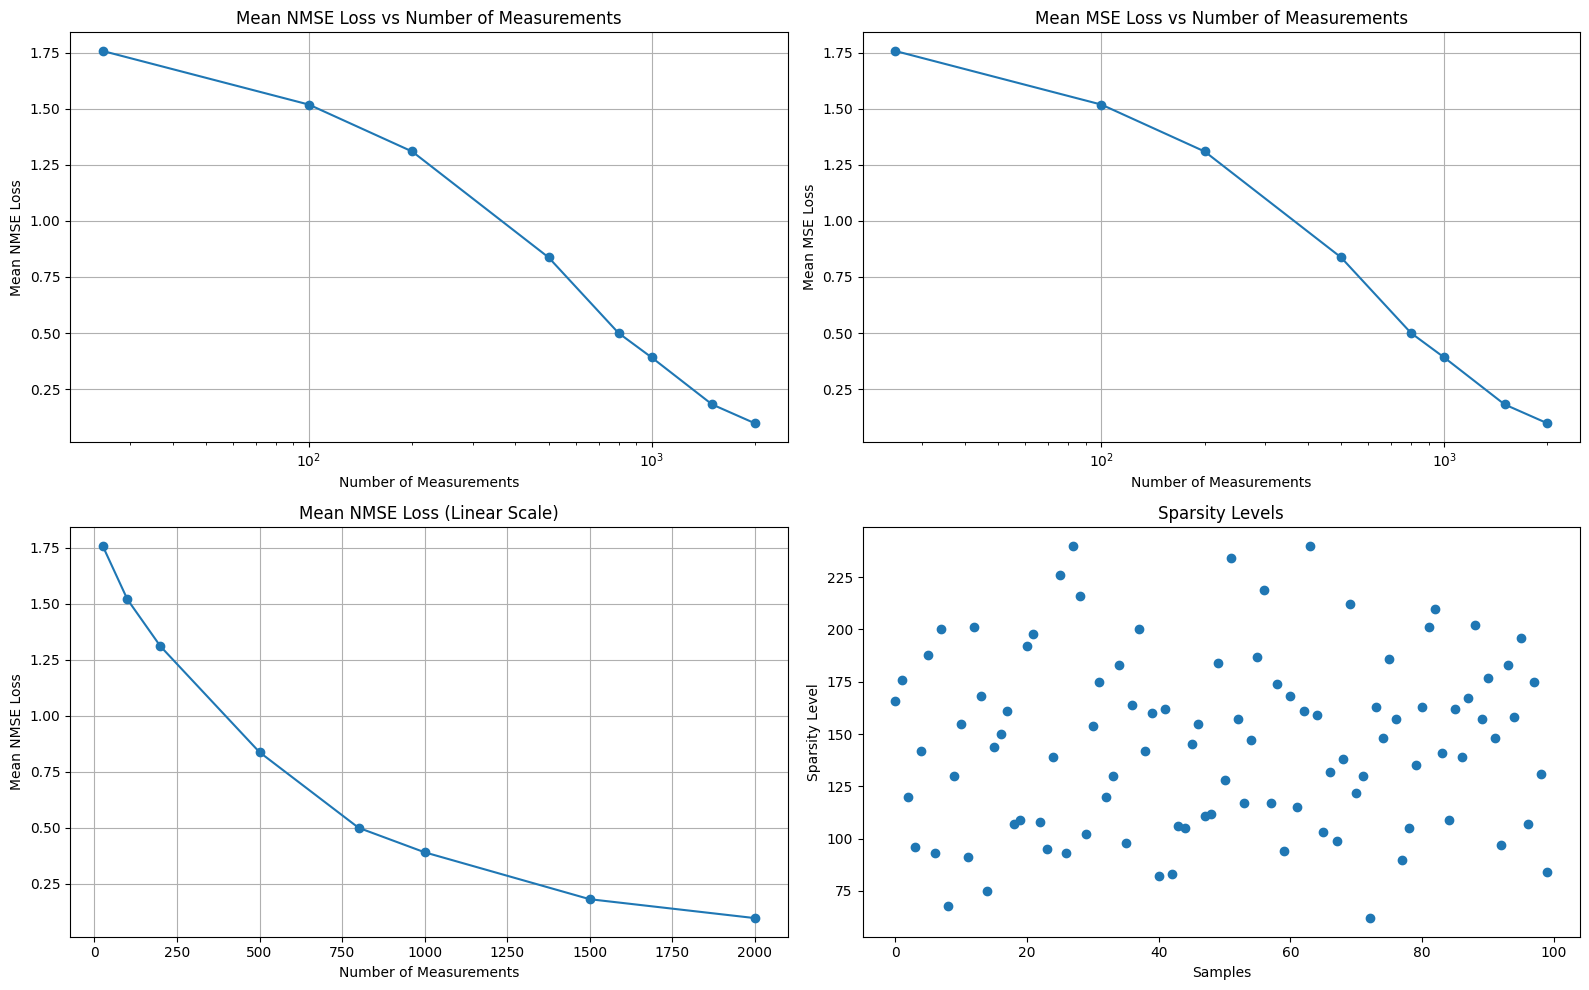

Measurements: [25, 100, 200, 500, 800, 1000, 1500, 2000]
Mean NMSE: [1.7581031273686114, 1.5187377451275994, 1.3097002050229682, 0.8374472400225621, 0.5001883539417711, 0.39092369564855367, 0.1816831188251323, 0.09743125714655992]
Mean MSE: [1.758103127368611, 1.5187377451275994, 1.3097002050229682, 0.8374472400225619, 0.5001883539417711, 0.3909236956485536, 0.18168311882513227, 0.09743125714655992]


In [8]:
set_seed(42)
with open('A_dict.pkl', 'rb') as f:
    A_dict = pickle.load(f)

def run_biht_without_tau(X_train, measurements):
    nmse_lists = [[] for _ in measurements]
    mse_lists = [[] for _ in measurements]
    sparsity_list = []

    # test for each m
    for m_idx, m in enumerate(measurements):
        m_str = str(m)
        print(f'Current Measurement: {m}')
        matrix = A_dict[m_str]

        for i in range(100):        # you can modify here to make it quick
            x_true = X_train[i]
            sparsity = Calculate_Sparse(x_true)
            
            if m_idx == 0:
                sparsity_list.append(sparsity)
            
            y = np.sign(matrix @ x_true)
            x_recovered = biht(matrix, y, sparsity, max_iter=1000)
            mse, nmse = compute_metrics(x_true, x_recovered)
            
            nmse_lists[m_idx].append(nmse)
            mse_lists[m_idx].append(mse)

    return nmse_lists, mse_lists, sparsity_list 

nmse_lists, mse_lists, sparsity_list = run_biht_without_tau(X_train, measurements)
mean_nmse_biht = [np.mean(nmse_list) for nmse_list in nmse_lists]
mean_mse = [np.mean(mse_list) for mse_list in mse_lists]

# plot results
plt.figure(figsize=(16, 10))

# NMSE Plot
plt.subplot(2, 2, 1)
plt.plot(measurements, mean_nmse_biht, 'o-')
plt.xlabel("Number of Measurements")
plt.ylabel("Mean NMSE Loss")
plt.title("Mean NMSE Loss vs Number of Measurements")
plt.xscale('log')
plt.grid(True)

# MSE Plot
plt.subplot(2, 2, 2)
plt.plot(measurements, mean_mse, 'o-')
plt.xlabel("Number of Measurements")
plt.ylabel("Mean MSE Loss")
plt.title("Mean MSE Loss vs Number of Measurements")
plt.xscale('log')
plt.grid(True)

# NMSE Detailed View
plt.subplot(2, 2, 3)
plt.plot(measurements, mean_nmse_biht, 'o-')
plt.xlabel("Number of Measurements")
plt.ylabel("Mean NMSE Loss")
plt.title("Mean NMSE Loss (Linear Scale)")
plt.grid(True)

# Sparsity Distribution
plt.subplot(2, 2, 4)
plt.plot(range(len(sparsity_list)), sparsity_list, 'o')
plt.title("Sparsity Levels")
plt.xlabel("Samples")
plt.ylabel("Sparsity Level")

plt.tight_layout()
plt.show()

print("Measurements:", measurements)
print("Mean NMSE:", mean_nmse_biht)
print("Mean MSE:", mean_mse)

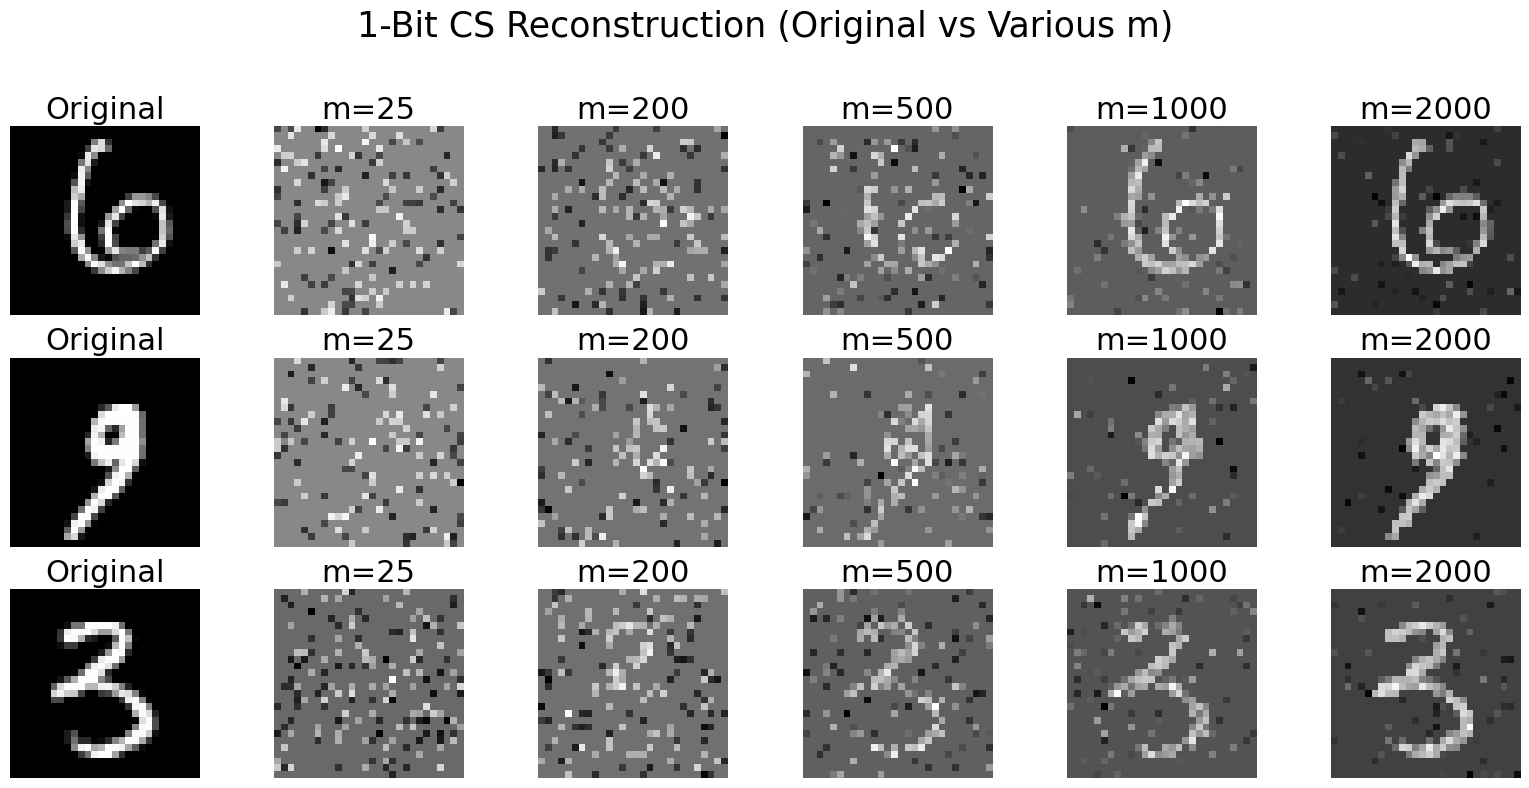

In [9]:
# Show the recovered images of BIHT

with open('A_dict.pkl', 'rb') as f:
    A_dict = pickle.load(f)

measurements_biht_show = [25, 200, 500, 1000, 2000]
sample_indices = [100, 1000, 5000]

def run_biht_no_norm(X_test, indices, measurements):
    results = []

    for idx in indices:
        x_true = X_test[idx]
        recon_list = []

        for m in measurements_biht_show:
            A = A_dict[str(m)]
            y = np.sign(A @ x_true)
            sparsity = Calculate_Sparse(x_true)
            x_recon = biht(A, y, sparsity, max_iter=1000)
            recon_list.append(x_recon)

        results.append((x_true, recon_list))

    return results


recon_results = run_biht_no_norm(X_test, sample_indices, measurements_biht_show)
fig, axes = plt.subplots(len(sample_indices), len(measurements_biht_show)+1, figsize=(16, 8))

for row, (x_true, x_recons) in enumerate(recon_results):
    axes[row, 0].imshow(x_true.reshape(28, 28), cmap='gray')
    axes[row, 0].set_title("Original", fontsize=22)
    axes[row, 0].axis('off')

    for col, x_recon in enumerate(x_recons):
        axes[row, col+1].imshow(x_recon.reshape(28, 28), cmap='gray')
        axes[row, col+1].set_title(f"m={measurements_biht_show[col]}", fontsize=22)
        axes[row, col+1].axis('off')

plt.suptitle("1-Bit CS Reconstruction (Original vs Various m)", fontsize=25)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## 2.2 Deep Learning Methods: FNN

Here we use FNN (Also known as MLP) to learn the mapping function between y and x. Use it to recover x from y

Using saved matrix: dimension 25
Training model with input_dim = 25...
Device: cuda


c:\Data\Software\anaconda3\envs\bayesian_project\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/50], LR: 0.001000, Train Loss: 0.022315, Test Loss: 0.000864, MSE: 6771.154558, NMSE: 0.812470
Epoch [2/50], LR: 0.001000, Train Loss: 0.001330, Test Loss: 0.000857, MSE: 6717.755357, NMSE: 0.802484
Epoch [3/50], LR: 0.001000, Train Loss: 0.001110, Test Loss: 0.000828, MSE: 6489.796429, NMSE: 0.762221
Epoch [4/50], LR: 0.001000, Train Loss: 0.000997, Test Loss: 0.000815, MSE: 6389.916085, NMSE: 0.756239
Epoch [5/50], LR: 0.001000, Train Loss: 0.000900, Test Loss: 0.000786, MSE: 6163.589230, NMSE: 0.704664
Epoch [6/50], LR: 0.001000, Train Loss: 0.000832, Test Loss: 0.000705, MSE: 5526.246757, NMSE: 0.641568
Epoch [7/50], LR: 0.001000, Train Loss: 0.000784, Test Loss: 0.000703, MSE: 5513.362740, NMSE: 0.633260
Epoch [8/50], LR: 0.001000, Train Loss: 0.000741, Test Loss: 0.000635, MSE: 4973.965240, NMSE: 0.571112
Epoch [9/50], LR: 0.001000, Train Loss: 0.000685, Test Loss: 0.000636, MSE: 4985.744173, NMSE: 0.576927
Epoch [10/50], LR: 0.001000, Train Loss: 0.000669, Test Loss: 0.

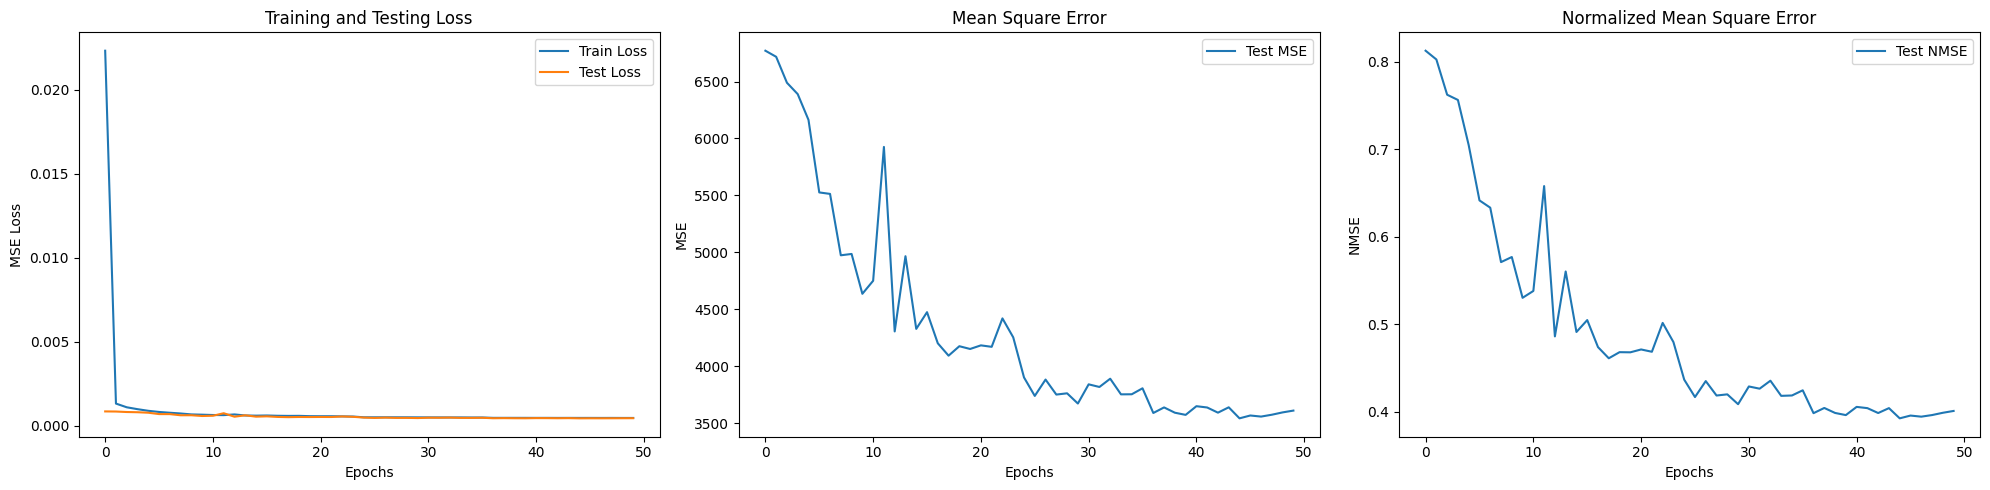

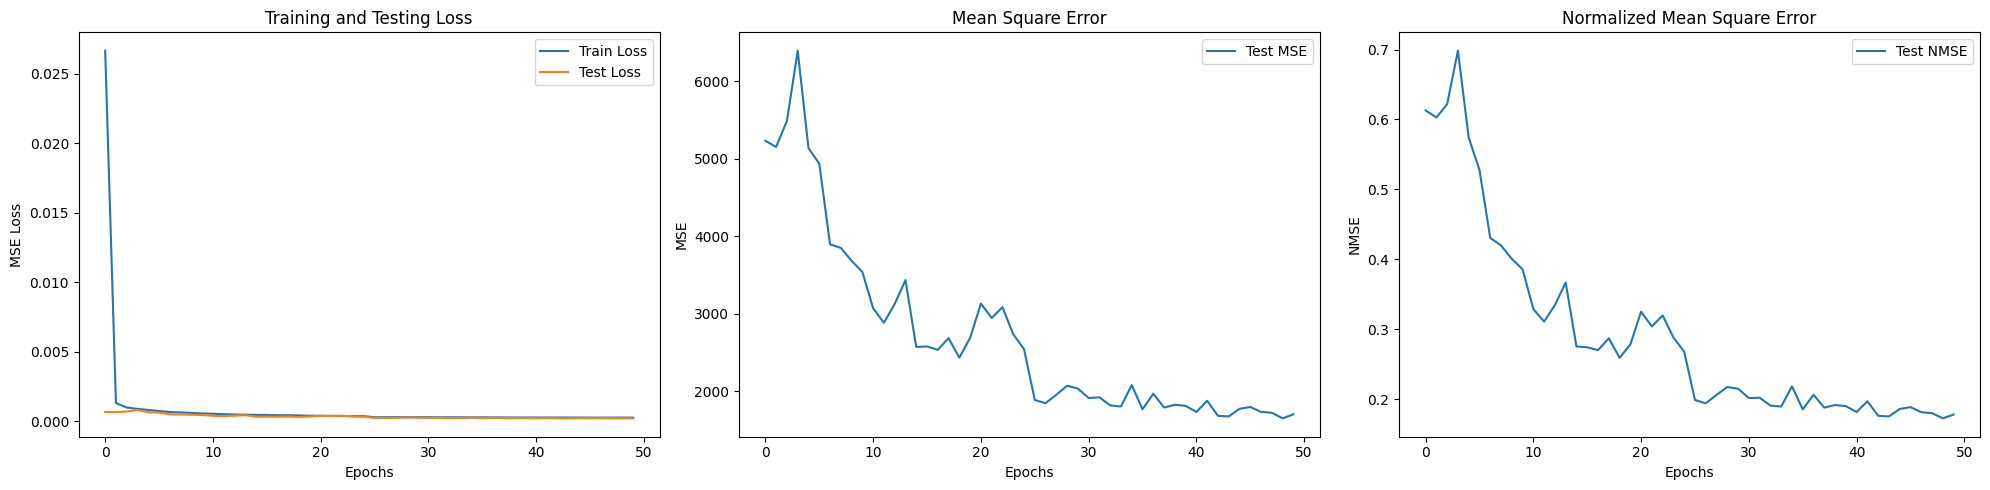

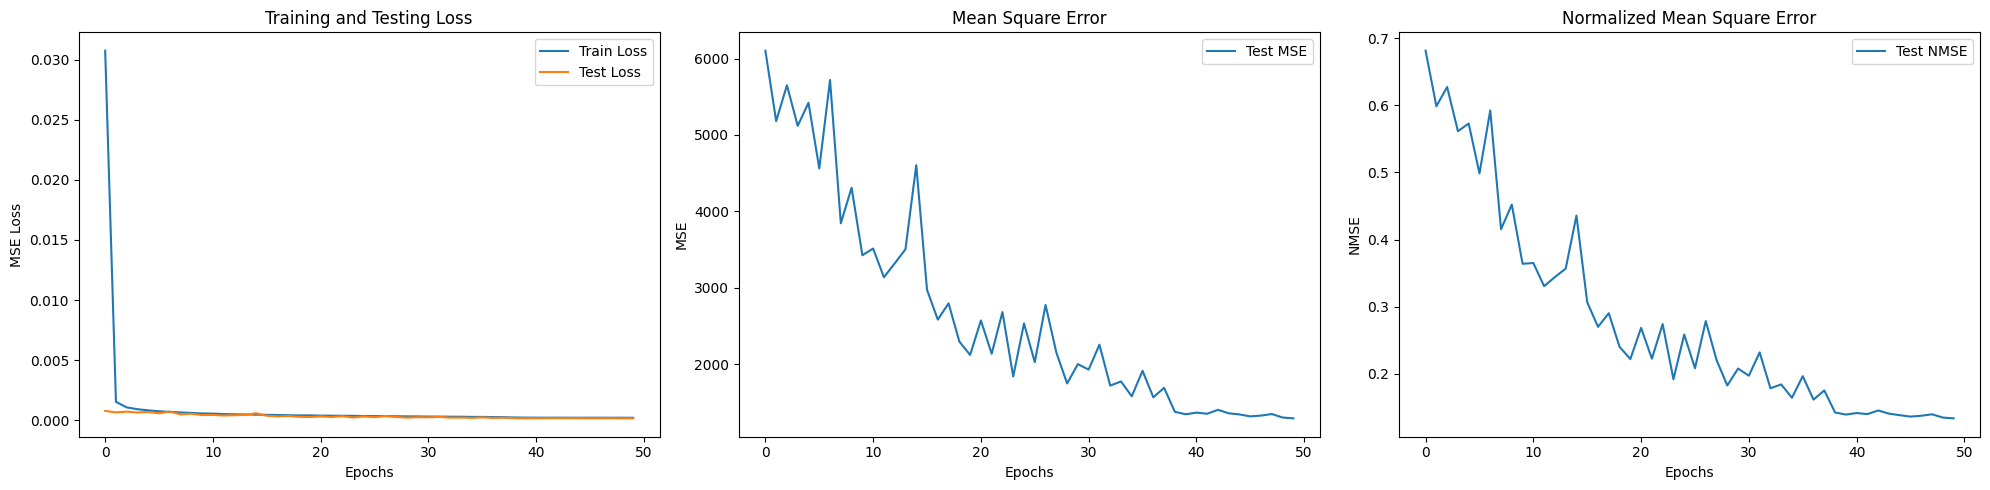

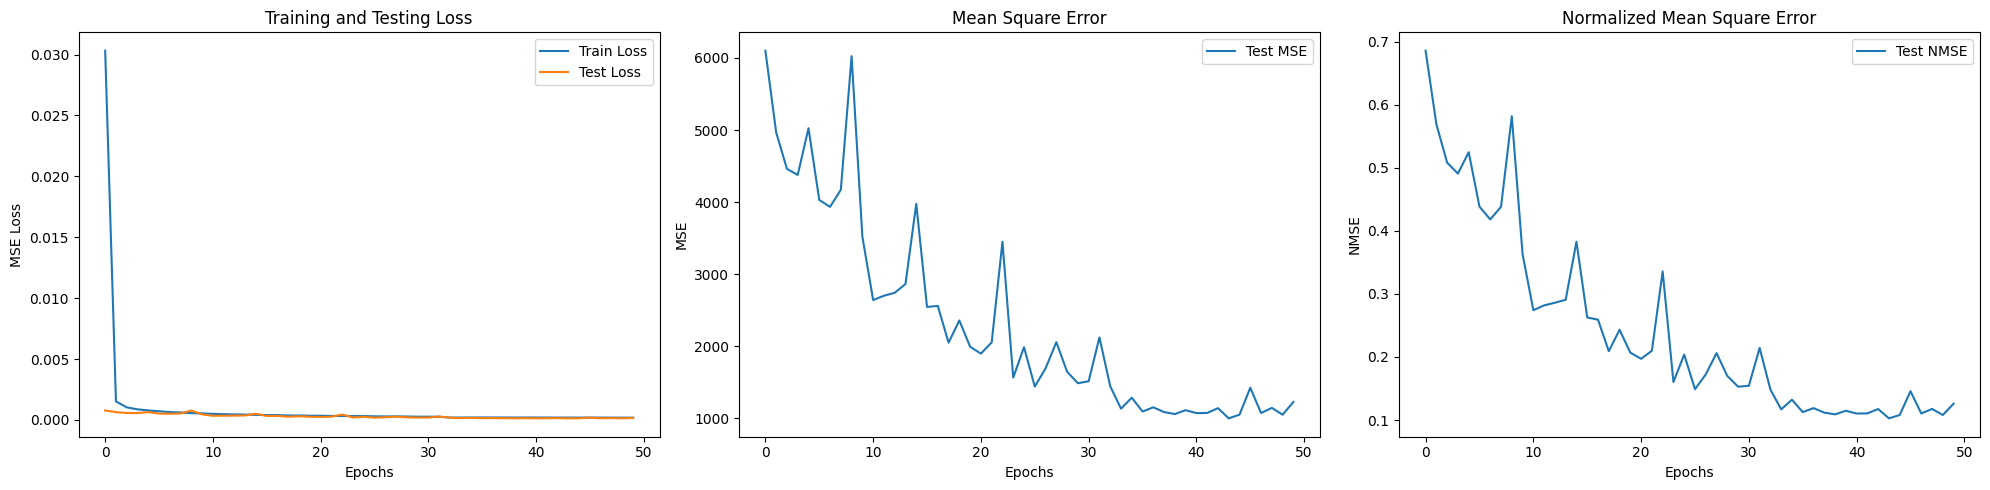

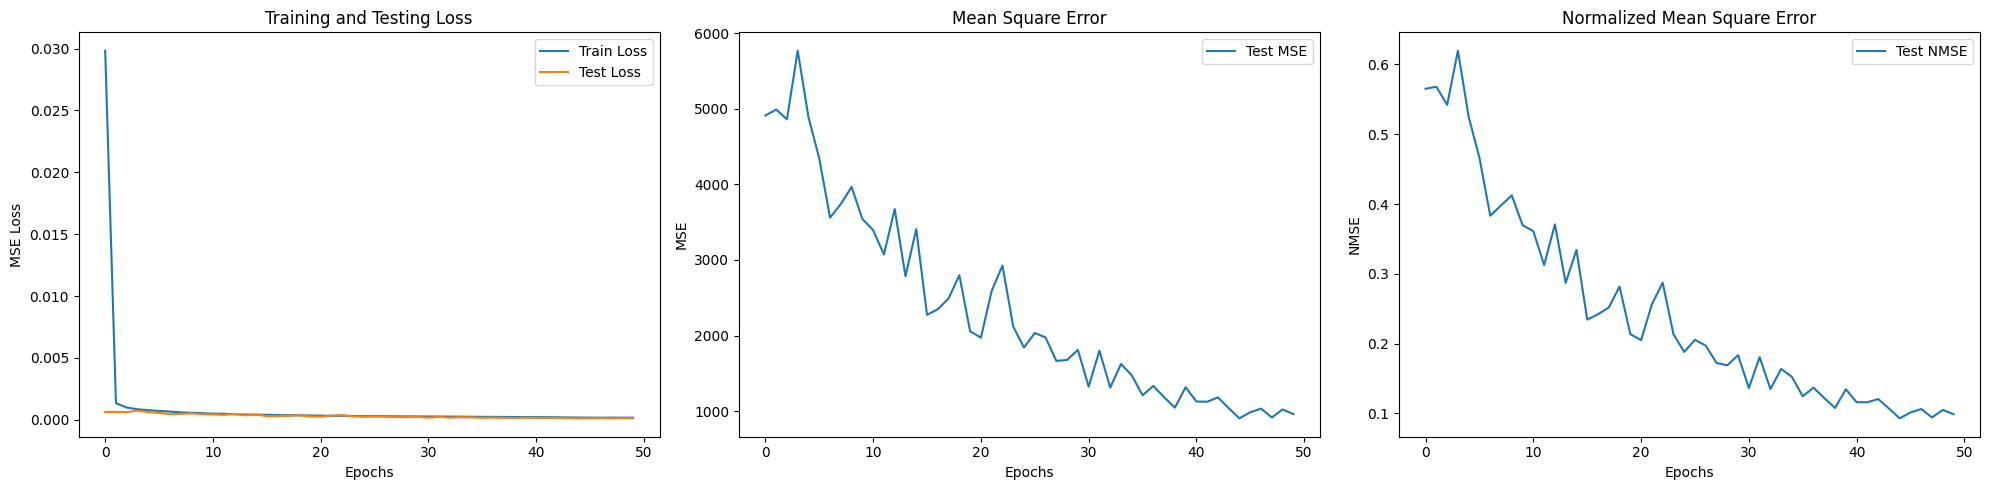

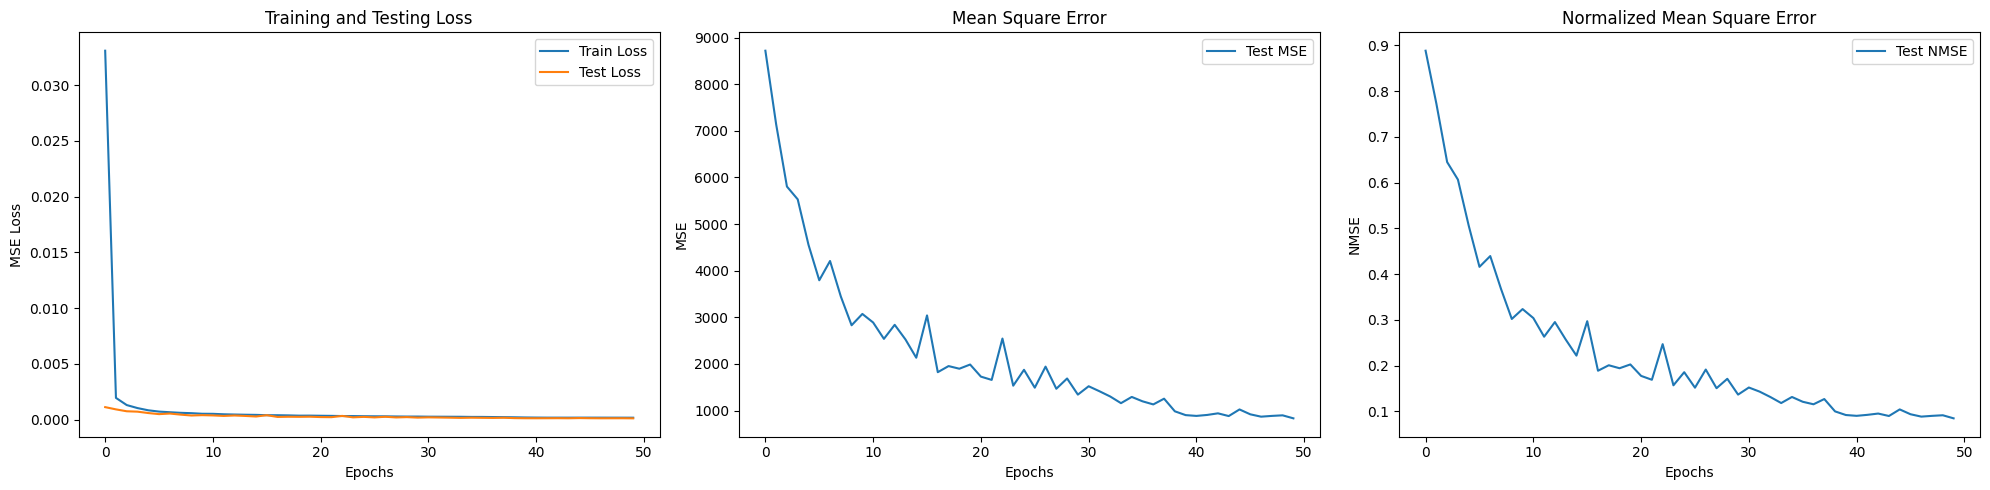

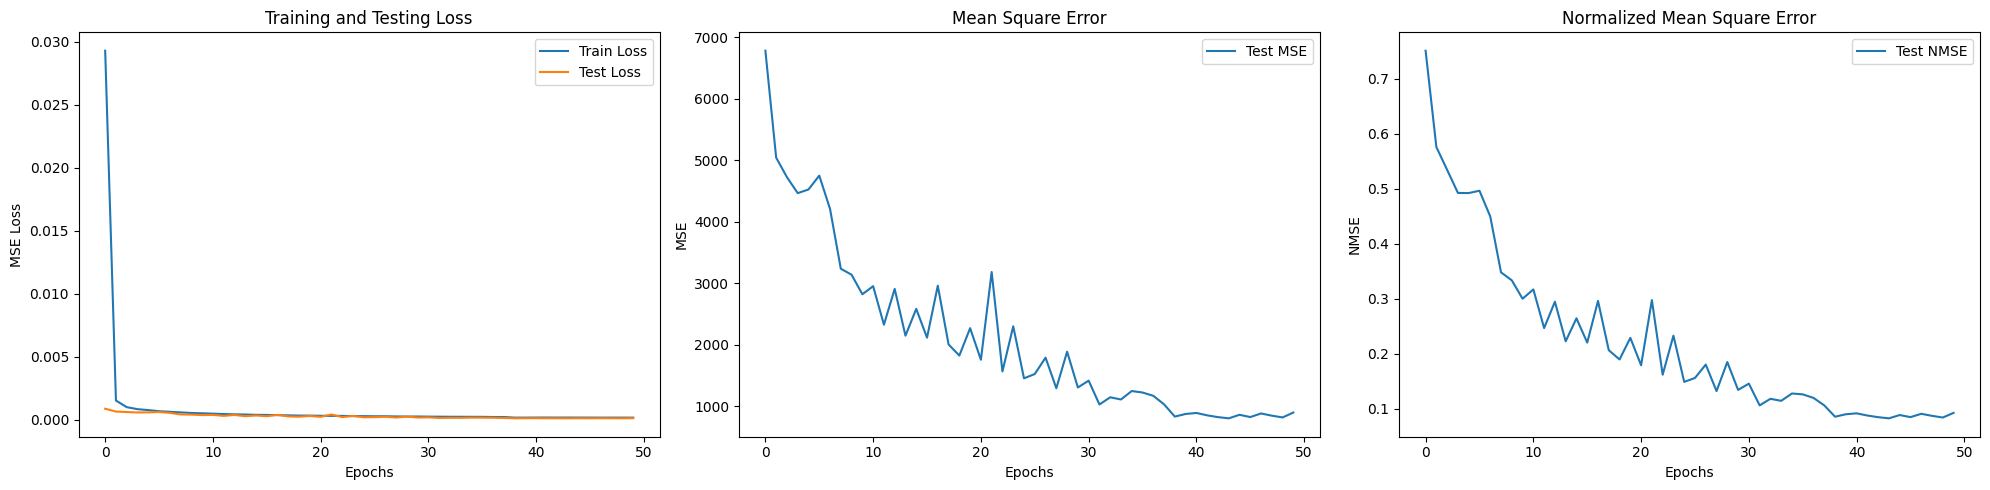

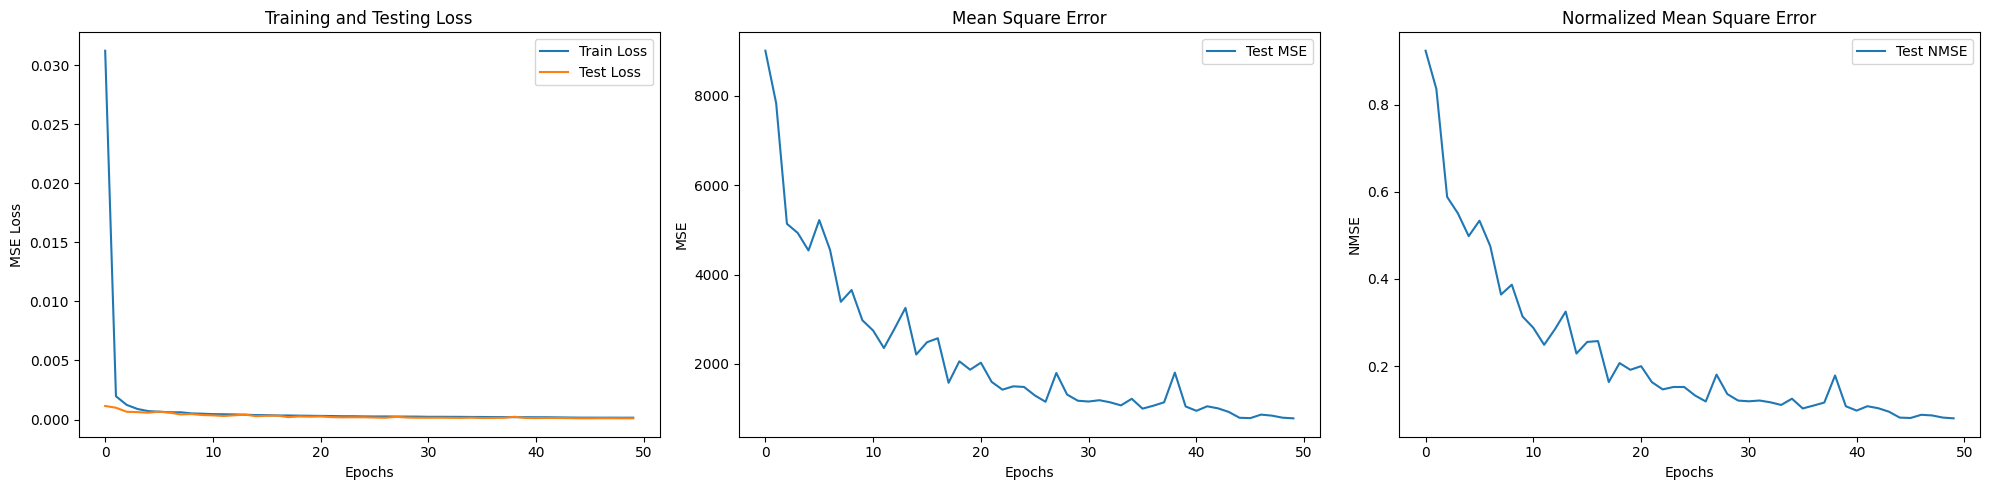

In [10]:
# Definition and training of the FNN(MLP)
# Set random seed and device
set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-generated measurement matrices
with open('A_dict.pkl', 'rb') as f:
    A_dict = pickle.load(f)

# Generate 1-bit measurements using sign(A @ X)
def generate_measurements(X, A):
    y = np.sign(A @ X.T).T
    return y

# Create PyTorch data loaders from numpy arrays
def create_data_loaders(y_data, x_data, batch_size=64):
    y_tensor = torch.from_numpy(y_data).float()
    x_tensor = torch.from_numpy(x_data).float()
    dataset = TensorDataset(y_tensor, x_tensor)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return data_loader

# Define a deep MLP model for 1-bit compressed sensing recovery
class EnhancedOnebitCSMLP(nn.Module):
    def __init__(self, input_dim=500, output_dim=784, dropout_rate=0.0):
        super(EnhancedOnebitCSMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 1024)
        self.bn2 = nn.BatchNorm1d(1024)
        self.fc3 = nn.Linear(1024, 2048)
        self.bn3 = nn.BatchNorm1d(2048)
        self.fc4 = nn.Linear(2048, 1024)
        self.bn4 = nn.BatchNorm1d(1024)
        self.fc5 = nn.Linear(1024, 1024)
        self.bn5 = nn.BatchNorm1d(1024)
        self.fc_out = nn.Linear(1024, output_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self._initialize_weights()

    # Initialize weights using Kaiming normal initialization
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    # Define forward through the network
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.leaky_relu(x, negative_slope=0.1)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = F.leaky_relu(x, negative_slope=0.1)
        x = self.dropout(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = F.leaky_relu(x, negative_slope=0.1)
        x = self.dropout(x)

        x = self.fc4(x)
        x = self.bn4(x)
        x = F.leaky_relu(x, negative_slope=0.1)
        x = self.dropout(x)

        x = self.fc5(x)
        x = self.bn5(x)
        x = F.leaky_relu(x, negative_slope=0.1)

        x = self.fc_out(x)
        return x

# Train the model and evaluate performance per epoch
def train_model(model, train_loader, test_loader, num_epochs=50, initial_lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}")

    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=initial_lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=True, min_lr=1e-6
    )

    train_losses, test_losses, test_mses, test_nmses, learning_rates = [], [], [], [], []

    for epoch in range(num_epochs):
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)

        model.train()
        epoch_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        test_loss = 0
        all_outputs, all_targets = [], []

        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                test_loss += loss.item()

                all_outputs.append(outputs.cpu().numpy())
                all_targets.append(targets.cpu().numpy())

        avg_test_loss = test_loss / len(test_loader)
        test_losses.append(avg_test_loss)

        outputs_array = np.vstack(all_outputs)
        targets_array = np.vstack(all_targets)
        mse, nmse = compute_metrics(targets_array, outputs_array)
        test_mses.append(mse)
        test_nmses.append(nmse)

        print(f'Epoch [{epoch+1}/{num_epochs}], LR: {current_lr:.6f}, Train Loss: {avg_train_loss:.6f}, Test Loss: {avg_test_loss:.6f}, MSE: {mse:.6f}, NMSE: {nmse:.6f}')
        scheduler.step(avg_test_loss)

    # Plot training and test metrics
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.title('Training and Testing Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(test_mses, label='Test MSE')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.title('Mean Square Error')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(test_nmses, label='Test NMSE')
    plt.xlabel('Epochs')
    plt.ylabel('NMSE')
    plt.title('Normalized Mean Square Error')
    plt.legend()

    plt.tight_layout()
    return model, train_losses, test_losses, test_mses, test_nmses, learning_rates

# Visualize a few reconstructed images and print error metrics
def visualize_results(model, test_loader, num_samples=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    all_inputs, all_targets, all_outputs = [], [], []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            all_inputs.append(inputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())
            all_outputs.append(outputs.cpu().numpy())

            if len(all_inputs) * inputs.shape[0] >= num_samples:
                break

    inputs_array = np.vstack(all_inputs)[:num_samples]
    targets_array = np.vstack(all_targets)[:num_samples]
    outputs_array = np.vstack(all_outputs)[:num_samples]

    mse_values, nmse_values = [], []
    for i in range(num_samples):
        mse, nmse = compute_metrics(targets_array[i], outputs_array[i])
        mse_values.append(mse)
        nmse_values.append(nmse)

    plt.figure(figsize=(15, 6))
    for i in range(num_samples):
        plt.subplot(2, num_samples, i+1)
        plt.imshow(targets_array[i].reshape(28, 28), cmap='gray')
        plt.title(f'Original {i+1}')
        plt.axis('off')

        plt.subplot(2, num_samples, i+1+num_samples)
        plt.imshow(outputs_array[i].reshape(28, 28), cmap='gray')
        plt.title(f'Recon {i+1}\nMSE: {mse_values[i]:.4f}\nNMSE: {nmse_values[i]:.4f}')
        plt.axis('off')

    avg_mse = np.mean(mse_values)
    avg_nmse = np.mean(nmse_values)

    print(f"Average MSE across all samples: {avg_mse:.6f}")
    print(f"Average NMSE across all samples: {avg_nmse:.6f}")

    plt.tight_layout()
    return avg_mse, avg_nmse

# Main training loop for different input dimensions
for input_dim in measurements:
    m_str = str(input_dim)

    # Load or skip depending on availability of measurement matrix
    if m_str in A_dict:
        A = A_dict[m_str]
        print(f"Using saved matrix: dimension {input_dim}")
    else:
        print(f"Matrix dimension {input_dim} not found, skipping...")
        continue

    # Generate measurements for training and test sets
    y_train = generate_measurements(X_train_DL, A)
    y_test = generate_measurements(X_test_DL, A)

    # Create data loaders
    train_loader = create_data_loaders(y_train, X_train, batch_size=100)
    test_loader = create_data_loaders(y_test, X_test, batch_size=100)
    print(f"Training model with input_dim = {input_dim}...")

    # Initialize and train the model
    model = EnhancedOnebitCSMLP(input_dim=input_dim, output_dim=784, dropout_rate=0.2)
    model, train_losses, test_losses, test_mses, test_nmses, lr_list = train_model(
        model, train_loader, test_loader, num_epochs=50
    )

    # Save trained model
    model_path = f"mlp_models/enhanced_onebit_cs_mlp_{input_dim}.pth"
    torch.save(model.state_dict(), model_path)
    print(f"Model saved at {model_path}")

    # Print final NMSE
    final_nmse = test_nmses[-1]
    print(f"Final NMSE (input_dim={input_dim}): {final_nmse:.6f}\n")


After training, we use it to recover the images on the test dataset. 

Evaluating model with input_dim = 25...
Using saved matrix: dimension 25
NMSE for input_dim=25: 0.424517

Evaluating model with input_dim = 100...
Using saved matrix: dimension 100
NMSE for input_dim=100: 0.176956

Evaluating model with input_dim = 200...
Using saved matrix: dimension 200
NMSE for input_dim=200: 0.126662

Evaluating model with input_dim = 500...
Using saved matrix: dimension 500
NMSE for input_dim=500: 0.105513

Evaluating model with input_dim = 800...
Using saved matrix: dimension 800
NMSE for input_dim=800: 0.096504

Evaluating model with input_dim = 1000...
Using saved matrix: dimension 1000
NMSE for input_dim=1000: 0.081593

Evaluating model with input_dim = 1500...
Using saved matrix: dimension 1500
NMSE for input_dim=1500: 0.104869

Evaluating model with input_dim = 2000...
Using saved matrix: dimension 2000
NMSE for input_dim=2000: 0.081559



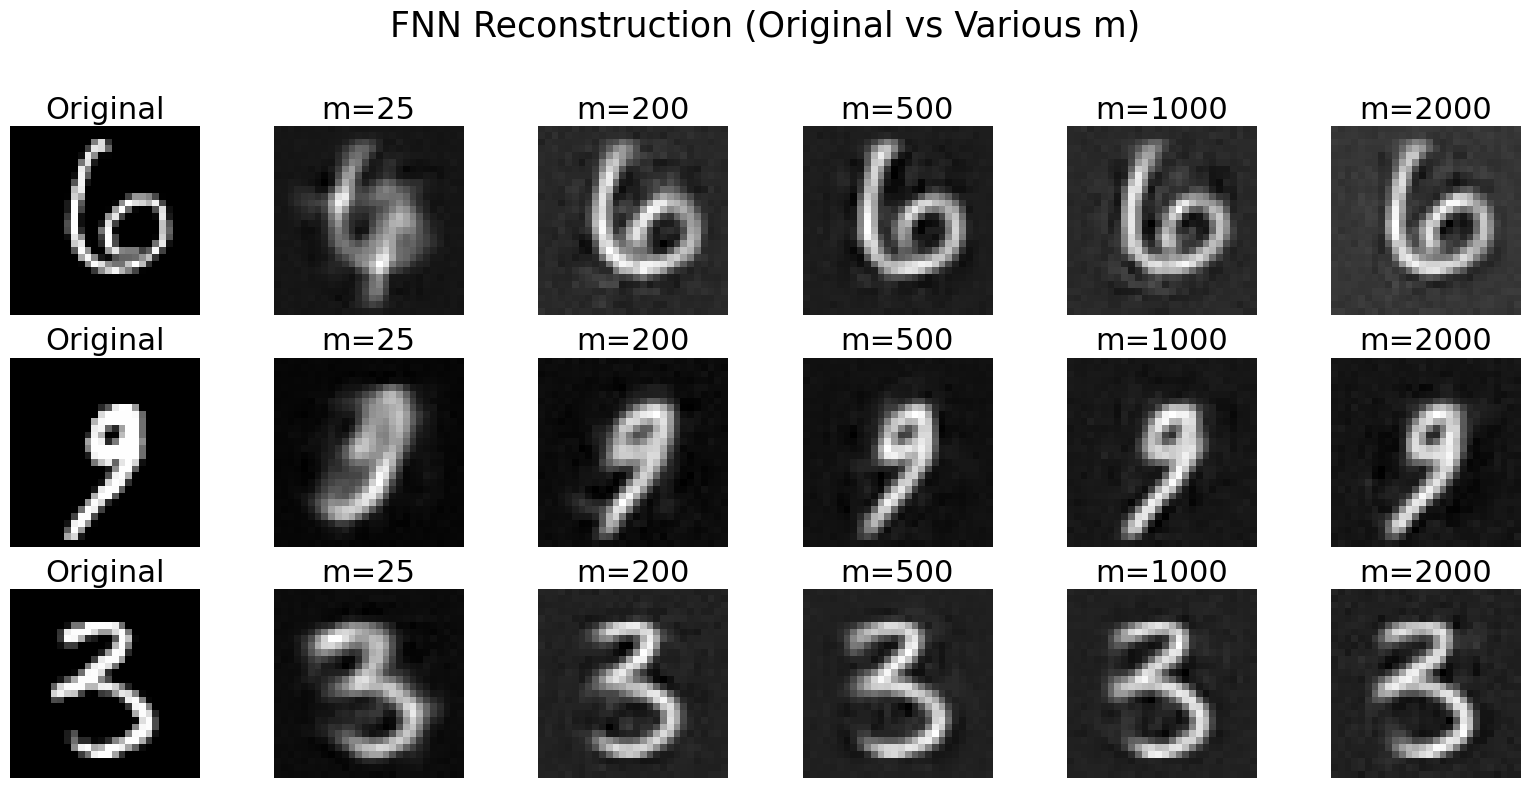

In [11]:
set_seed(42)
nmse_values_mlp = []

# Load the saved A matrices
with open('A_dict.pkl', 'rb') as f:
    A_dict = pickle.load(f)

for input_dim in measurements:
    m_str = str(input_dim)
    print(f"Evaluating model with input_dim = {input_dim}...")
    
    # Use the pre-saved matrix if available
    if m_str in A_dict:
        A = A_dict[m_str]
        print(f"Using saved matrix: dimension {input_dim}")
    else:
        print(f"Matrix with dimension {input_dim} not found, skipping...")
        continue
    
    # Generate measurement data
    y_train = generate_measurements(X_train, A)
    y_test = generate_measurements(X_test, A)
    
    # Create data loaders
    train_loader = create_data_loaders(y_train, X_train, batch_size=100)
    test_loader = create_data_loaders(y_test, X_test, batch_size=100)
    
    # Initialize model
    model = EnhancedOnebitCSMLP(input_dim=input_dim, output_dim=784, dropout_rate=0.2)
    
    # Load the trained model
    model_path = f"mlp_models/enhanced_onebit_cs_mlp_{input_dim}.pth"
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()  # Switch to evaluation mode
    
    # Get the first 100 test samples
    test_iter = iter(test_loader)
    inputs, targets = next(test_iter)
    inputs, targets = inputs[:100].to(device), targets[:100].to(device)

    # Forward pass
    with torch.no_grad():
        outputs = model(inputs)

    # Compute MSE and NMSE
    targets_np = targets.cpu().numpy()
    outputs_np = outputs.cpu().numpy()
    
    # Assume compute_metrics returns a tuple (mse, nmse)
    mse, nmse = compute_metrics(targets_np, outputs_np)
    nmse_values_mlp.append(nmse)

    print(f"NMSE for input_dim={input_dim}: {nmse:.6f}\n")


# -------- Compare -----------

measurements_fnn_show = [25, 200, 500, 1000, 2000]
sample_indices = [100, 1000, 5000]

# Load A matrices
with open('A_dict.pkl', 'rb') as f:
    A_dict = pickle.load(f)

# Store reconstruction results
all_outputs = []
all_targets = []

for sample_idx in sample_indices:
    recon_images = []
    target_image = None

    for m in measurements_fnn_show:
        A = A_dict[str(m)]
        x = X_test[sample_idx]
        y = np.sign(A @ x)

        input_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(0).to(device)

        model = EnhancedOnebitCSMLP(input_dim=m, output_dim=784, dropout_rate=0.2)
        model_path = f"mlp_models/enhanced_onebit_cs_mlp_{m}.pth"
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.to(device)
        model.eval()

        with torch.no_grad():
            output = model(input_tensor).cpu().numpy().squeeze()
            recon_images.append(output.reshape(28, 28))

        if target_image is None:
            target_image = x.reshape(28, 28)

    all_outputs.append(recon_images)
    all_targets.append(target_image)

# Visualization
fig, axes = plt.subplots(len(sample_indices), len(measurements_fnn_show) + 1, figsize=(16, 8))

for row in range(len(sample_indices)):
    # Original image
    axes[row, 0].imshow(all_targets[row], cmap='gray')
    axes[row, 0].set_title("Original", fontsize=22)
    axes[row, 0].axis('off')

    for col in range(len(measurements_fnn_show)):
        axes[row, col + 1].imshow(all_outputs[row][col], cmap='gray')
        axes[row, col + 1].set_title(f"m={measurements_fnn_show[col]}", fontsize=22)
        axes[row, col + 1].axis('off')

plt.suptitle("FNN Reconstruction (Original vs Various m)", fontsize=25)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# 2.3 VAEs

Define the structure of VAE and train it. 

Epoch 1 Batch 0 Loss: 543.0630
Epoch 1 Batch 100 Loss: 203.6675
Epoch 1 Batch 200 Loss: 181.0277
Epoch 1 Batch 300 Loss: 144.5822
Epoch 1 Batch 400 Loss: 148.7269
====> Epoch: 1 Average loss: 176.1889
====> Test set loss: 138.5232
Epoch 2 Batch 0 Loss: 135.6158
Epoch 2 Batch 100 Loss: 131.7126
Epoch 2 Batch 200 Loss: 129.2398
Epoch 2 Batch 300 Loss: 130.2962
Epoch 2 Batch 400 Loss: 120.5713
====> Epoch: 2 Average loss: 128.7182
====> Test set loss: 120.5250
Epoch 3 Batch 0 Loss: 120.4214
Epoch 3 Batch 100 Loss: 119.6124
Epoch 3 Batch 200 Loss: 116.3569
Epoch 3 Batch 300 Loss: 113.8847
Epoch 3 Batch 400 Loss: 122.5089
====> Epoch: 3 Average loss: 117.8907
====> Test set loss: 113.8013
Epoch 4 Batch 0 Loss: 114.3861
Epoch 4 Batch 100 Loss: 116.5120
Epoch 4 Batch 200 Loss: 112.1672
Epoch 4 Batch 300 Loss: 112.8524
Epoch 4 Batch 400 Loss: 109.9071
====> Epoch: 4 Average loss: 112.7697
====> Test set loss: 110.5362
Epoch 5 Batch 0 Loss: 112.5775
Epoch 5 Batch 100 Loss: 109.8832
Epoch 5 Batc

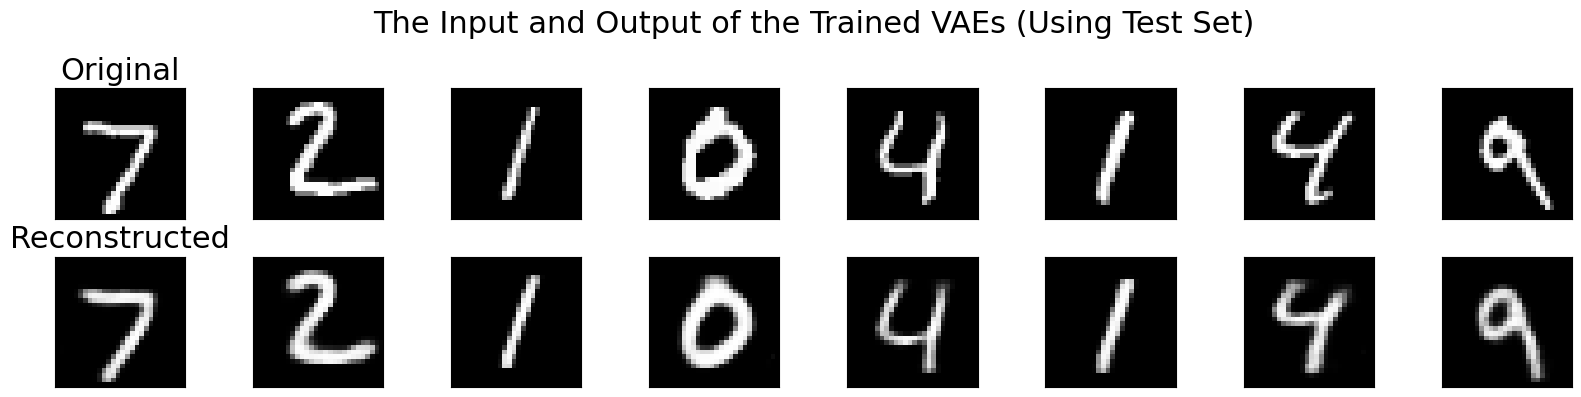

In [12]:
set_seed(42)
# Encoder: 784 → 512 → 256 → (mu, logvar)
class Encoder(nn.Module):
    def __init__(self, input_dim=784, hidden_dim1=512, hidden_dim2=256, latent_dim=20):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc_mu = nn.Linear(hidden_dim2, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim2, latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        h = self.relu(self.fc1(x))
        h = self.relu(self.fc2(h))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

# Decoder: latent_dim → 256 → 512 → 784
class Decoder(nn.Module):
    def __init__(self, latent_dim=20, hidden_dim1=256, hidden_dim2=512, output_dim=784):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        h = self.relu(self.fc1(z))
        h = self.relu(self.fc2(h))
        x_recon = self.sigmoid(self.fc3(h))
        x_recon = x_recon.view(-1, 1, 28, 28)
        return x_recon

# Full VAE
class VAE(nn.Module):
    def __init__(self, input_dim=784, latent_dim=20):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim=input_dim, latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim, output_dim=input_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

def loss_function(x_recon, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(x_recon, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


def train(epoch, model, optimizer, train_loader, device):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Epoch {epoch} Batch {batch_idx} Loss: {loss.item()/len(data):.4f}')
    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')

def test(model, test_loader, device):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon, mu, logvar = model(data)
            test_loss += loss_function(recon, data, mu, logvar).item()
    test_loss /= len(test_loader.dataset)
    print(f'====> Test set loss: {test_loss:.4f}')

def compare_images(model, device, test_loader, num_images=8):
    model.eval()
    with torch.no_grad():
        # compare some images
        data, _ = next(iter(test_loader))
        data = data.to(device)
        recon, _, _ = model(data)

    data = data.cpu().numpy()
    recon = recon.cpu().numpy()

    plt.figure(figsize=(num_images * 2, 4))
    plt.suptitle("The Input and Output of the Trained VAEs (Using Test Set)", fontsize=22)
    for i in range(num_images):
        # original images
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(data[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == 0:
            ax.set_title("Original", fontsize=22)

        # recovered
        ax = plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(recon[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        if i == 0:
            ax.set_title("Reconstructed", fontsize=22)
    
    plt.tight_layout()
    plt.show()

batch_size = 128
epochs = 50
latent_dim = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
transform = transforms.ToTensor()
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = VAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# See some images about the distribution of vae (latent space)
for epoch in range(1, epochs + 1):
    train(epoch, model, optimizer, train_loader, device)
    test(model, test_loader, device)
    # compare_images(model, device, test_loader, num_images=8)
compare_images(model, device, test_loader, num_images=8)

After training VAE, see the latent space by showing some images and use it to recover the images. 

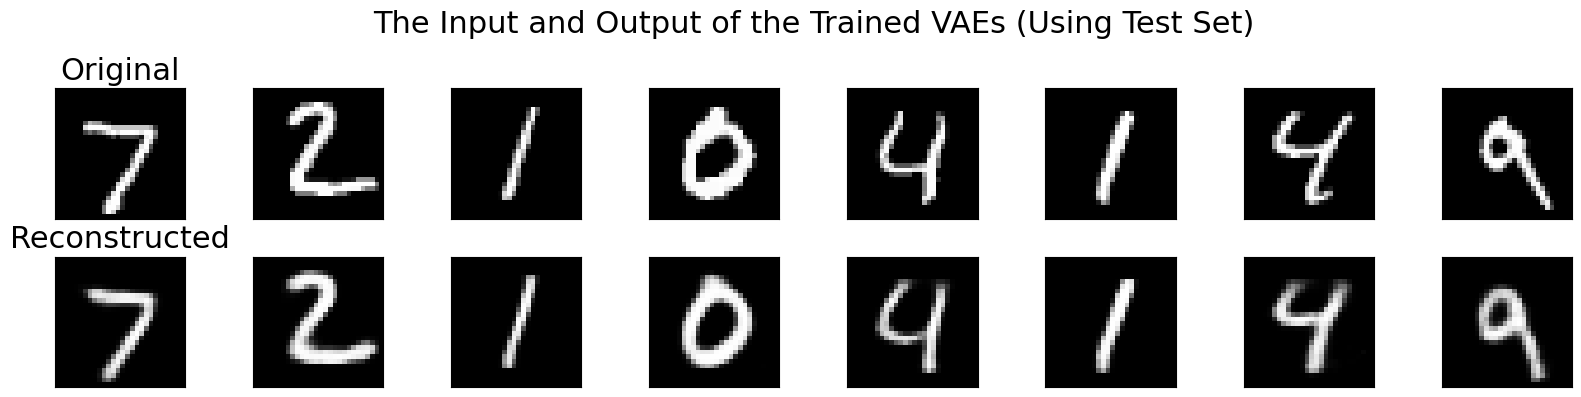

C:\Users\84805\AppData\Local\Temp\ipykernel_28440\2133162740.py:41: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:3729.)
  y_hat = (A @ x_hat.T).squeeze()  # Shape: [m]


Step 0, Loss: 1.420786
Step 1000, Loss: 0.556300
Step 2000, Loss: 0.543231
Step 3000, Loss: 0.527527
Step 4000, Loss: 0.519726
Step 5000, Loss: 0.515443
Step 6000, Loss: 0.512576
Step 7000, Loss: 0.511178
Step 8000, Loss: 0.507807
Step 9000, Loss: 0.506567


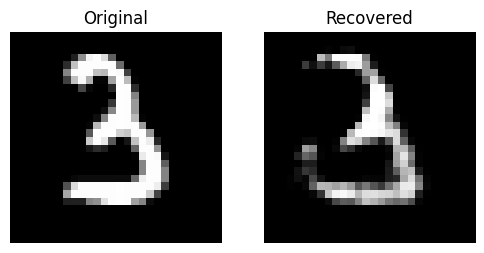

In [13]:
set_seed(42)  # Set random seed for reproducibility
compare_images(model, device, test_loader, num_images=8)

vae = model
vae.decoder.eval()  # Set decoder to evaluation mode

# Load predefined measurement matrices from a dictionary
with open("A_dict.pkl", "rb") as f:
    A_dict = pickle.load(f)

# Choose a measurement matrix with m = 200 rows
A = A_dict['200']  # Shape: [100, 784]
A = torch.tensor(A, dtype=torch.float32).to(device)

# Randomly select one test sample
idx = torch.randint(0, len(X_test_tensor), (1,))
x_star = X_test_tensor[idx].to(device)  # Shape: [1, 784]

# Get one-bit measurements y = sign(A·x)
y = torch.sign(A @ x_star.T).squeeze()  # Shape: [100]

# Initialize latent variable z as the optimization target
z = torch.randn(1, latent_dim, requires_grad=True, device=device)

optimizer = optim.Adam([z], lr=1e-2)  # Optimizer for z
m = A.shape[0]
sqrt_2pi_over_m = torch.sqrt(torch.tensor(2 * torch.pi))  # Optional constant (not used)

sqrt_2_pi = np.sqrt(2 / np.pi)  # Optional constant (not used)

# Start optimization loop
for step in range(10000):
    optimizer.zero_grad()

    # Decode latent vector to image
    x_hat = vae.decoder(z)  # [1, 784]
    x_hat = x_hat.view(-1, 784)
    x_hat = x_hat.squeeze()

    # Get prediction (linear measurement from decoder output)
    y_hat = (A @ x_hat.T).squeeze()  # Shape: [m]

    # Compute loss: measurement consistency + regularization
    pred = A @ x_hat.T
    residual = pred - y
    loss = torch.mean(residual ** 2) + 0.002 * torch.norm(x_hat) ** 2

    loss.backward()
    optimizer.step()

    if step % 1000 == 0:
        print(f"Step {step}, Loss: {loss.item():.6f}")

# Normalize the recovered signal
x_hat = x_hat / torch.norm(x_hat)

# Reshape tensors for visualization
x_hat_img = x_hat.view(28, 28).detach().cpu().numpy()
x_star_img = x_star.view(28, 28).cpu().numpy()

# Plot original and reconstructed images
plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.imshow(x_star_img, cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(x_hat_img, cmap='gray')
plt.title("Recovered")
plt.axis('off')

plt.show()


### 2.4.1 Compare Objective Function

We compare two different loss functions

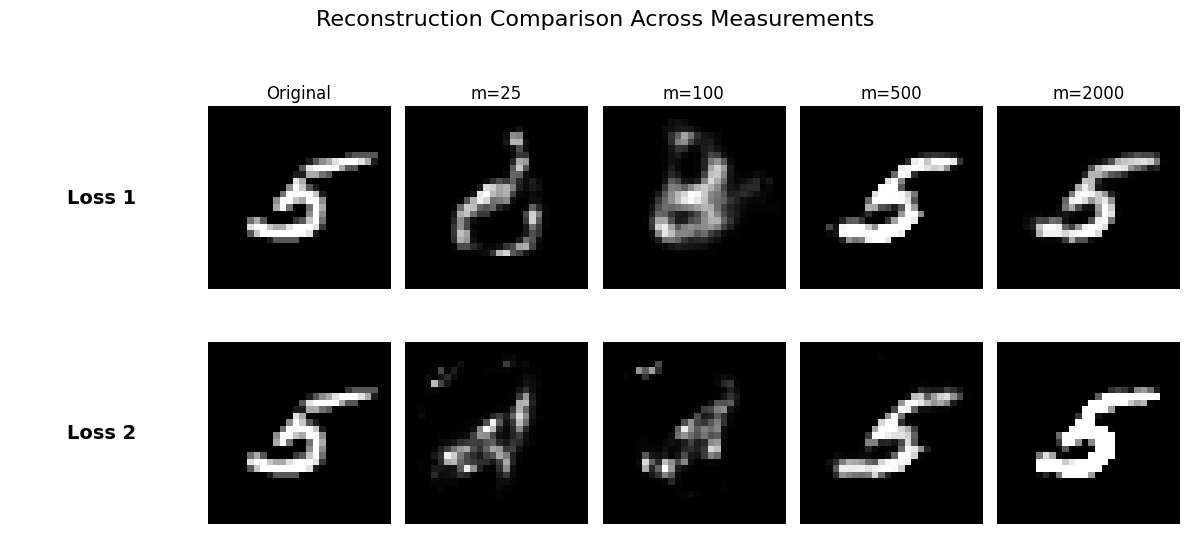

In [14]:
set_seed(42)

vae = model
vae.decoder.eval()

with open("A_dict.pkl", "rb") as f:
    A_dict = pickle.load(f)

measurement_list = ['25', '100', '500', '2000']
latent_dim = vae.decoder.fc1.in_features

idx = torch.randint(0, len(X_test_tensor), (1,))
x_star = X_test_tensor[idx.item()].to(device)
x_star_img = x_star.view(28, 28).cpu().numpy()

recon_images_mse = []
recon_images_corr = []

for m_str in measurement_list:
    A = torch.tensor(A_dict[m_str], dtype=torch.float32).to(device)
    y = torch.sign(A @ x_star.T).squeeze()
    m = A.shape[0]

    for loss_type in ['mse', 'corr']:
        z = torch.randn(1, latent_dim, requires_grad=True, device=device)
        optimizer = torch.optim.Adam([z], lr=1e-2)

        for step in range(60000):
            optimizer.zero_grad()
            x_hat = vae.decoder(z).view(-1)

            if loss_type == 'mse':
                pred = A @ x_hat
                residual = pred - y
                loss = torch.mean(residual ** 2) + 0.002 * torch.norm(x_hat) ** 2
            else:
                corr_term = torch.dot(y, A @ x_hat)
                loss = torch.norm(x_hat) ** 2 - np.sqrt(2 / np.pi) * corr_term

            loss.backward()
            optimizer.step()

        x_hat = x_hat / torch.norm(x_hat)
        img = x_hat.view(28, 28).detach().cpu().numpy()

        if loss_type == 'mse':
            recon_images_mse.append(img)
        else:
            recon_images_corr.append(img)

n_rows = 2
n_cols = len(measurement_list) + 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2.8))

col_titles = ["Original"] + [f"m={m}" for m in measurement_list]
row_labels = ["Loss 1", "Loss 2"]

for col in range(1, n_cols):
    axes[0, col].set_title(col_titles[col - 1], fontsize=12)

for row in range(n_rows):
    for col in range(n_cols):
        ax = axes[row, col]
        ax.axis('off')
        if col == 0:
            ax.text(0.5, 0.5, row_labels[row], ha='center', va='center', fontsize=14, weight='bold')
        elif col == 1:
            ax.imshow(x_star_img, cmap='gray')
        else:
            if row == 0:
                ax.imshow(recon_images_mse[col - 2], cmap='gray')
            else:
                ax.imshow(recon_images_corr[col - 2], cmap='gray')

plt.suptitle("Reconstruction Comparison Across Measurements", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


Compare the performance of VAEs under different m

1.5381336984182923
0.726614626953964
1.3643141866101018
1.0935105829494205
1.0565732235312595
0.3017801435919729
0.6372209836953893
0.31835531911794135
0.24846408962275746
0.4201195509860014
0.08953108988868053
0.07480043802548053
0.1487517673614045
0.12875942158544618
0.11398605030216746
0.17402622383812982
0.09725243706114739
0.09780155307780447
0.185202179029603
0.08033420931576885
0.20167556803503217
0.21188492312902785
0.10230396387271767
0.11049395640851944


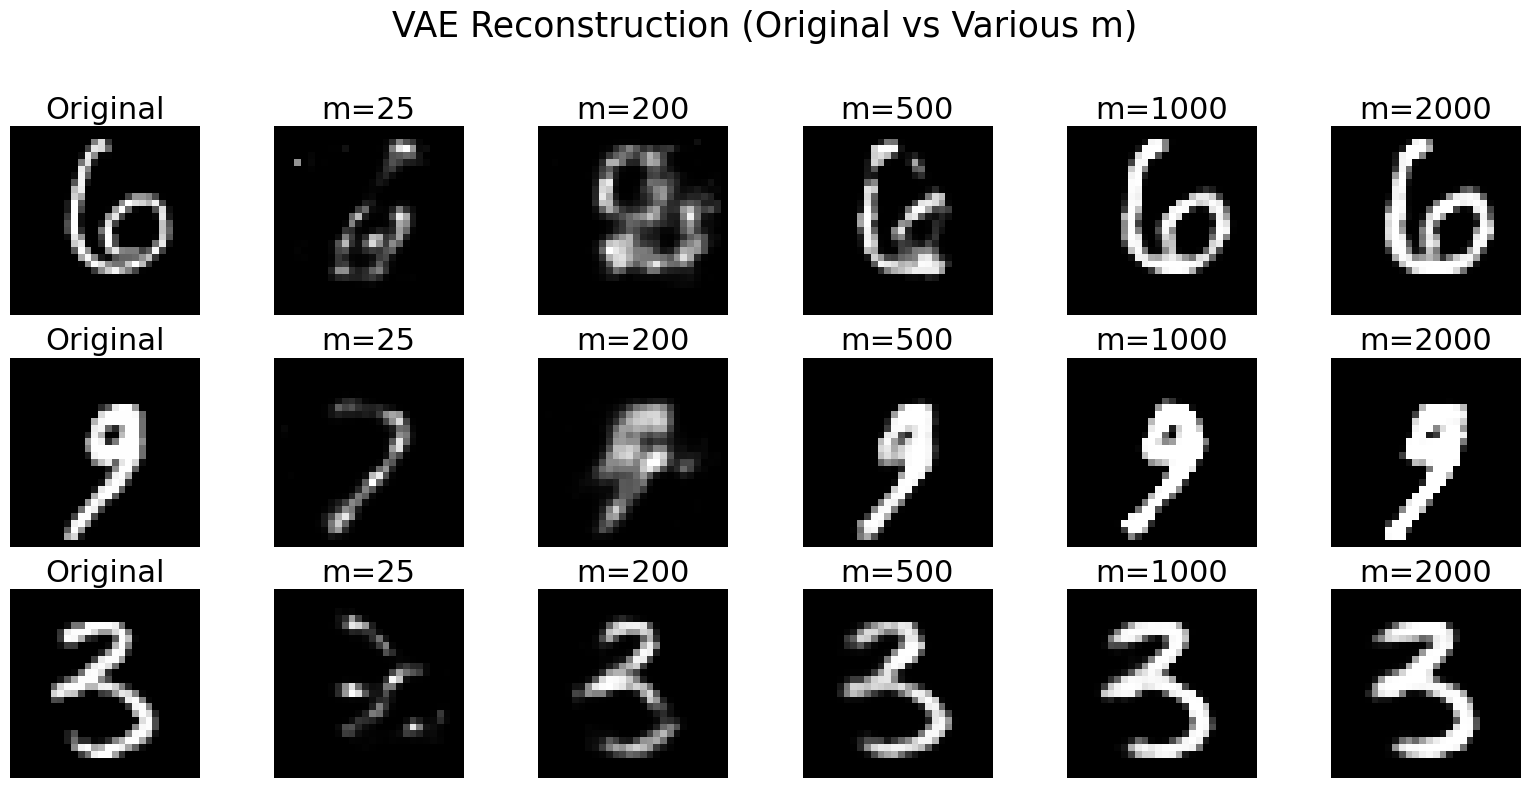

NMSE per measurement:
m=25: NMSE=1.2097
m=100: NMSE=0.8173
m=200: NMSE=0.4013
m=500: NMSE=0.1948
m=800: NMSE=0.1305
m=1000: NMSE=0.1230
m=1500: NMSE=0.1557
m=2000: NMSE=0.1416


In [15]:
set_seed(42)
vae.decoder.eval()

sample_indices = [100, 1000, 5000]
measurements_to_display = [25, 200, 500, 1000, 2000]
latent_dim = vae.decoder.fc1.in_features

# Load measurement matrices
with open("A_dict.pkl", "rb") as f:
    A_dict = pickle.load(f)

nmse_vae_list = []
recon_results = [[] for _ in sample_indices]  # One row per sample

for m in measurements:
    A = torch.tensor(A_dict[str(m)], dtype=torch.float32).to(device)
    nmse_sum = 0
    recon_images_for_show = []

    for idx in sample_indices:
        x_star = X_test_tensor[idx].to(device)
        y = torch.sign(A @ x_star.T).squeeze()

        z = torch.randn(1, latent_dim, requires_grad=True, device=device)
        optimizer = optim.Adam([z], lr=1e-2)
        sqrt_2_pi = np.sqrt(2 / np.pi)

        for step in range(10000):
            optimizer.zero_grad()
            x_hat = vae.decoder(z).view(-1, 784).squeeze()
            norm_term = torch.norm(x_hat) ** 2
            corr_term = torch.dot(y, A @ x_hat)
            loss = 0.85 * norm_term - sqrt_2_pi * corr_term
            loss.backward()
            optimizer.step()

        x_hat_img = x_hat.view(28, 28).detach().cpu().numpy()

        # Compute NMSE
        x_star_flat = x_star.view(-1).cpu().numpy()
        x_hat_flat = x_hat.detach().cpu().numpy()
        mse, nmse = compute_metrics(x_star_flat, x_hat_flat)
        print(nmse)
        nmse_sum += nmse

        # Save reconstruction if current m is in display list
        if m in measurements_to_display:
            recon_results[sample_indices.index(idx)].append(x_hat_img)

    nmse_avg = nmse_sum / len(sample_indices)
    nmse_vae_list.append(nmse_avg)

# Get original images
original_images = [X_test_tensor[idx].view(28, 28).cpu().numpy() for idx in sample_indices]

# Plotting
fig, axes = plt.subplots(len(sample_indices), len(measurements_to_display) + 1, figsize=(16, 8))

for row in range(len(sample_indices)):
    axes[row, 0].imshow(original_images[row], cmap='gray')
    axes[row, 0].set_title("Original", fontsize=22)
    axes[row, 0].axis('off')

    for col in range(len(measurements_to_display)):
        axes[row, col + 1].imshow(recon_results[row][col], cmap='gray')
        axes[row, col + 1].set_title(f"m={measurements_to_display[col]}", fontsize=22)
        axes[row, col + 1].axis('off')

plt.suptitle("VAE Reconstruction (Original vs Various m)", fontsize=25)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Print NMSE for all m
print("NMSE per measurement:")
for m, nmse in zip(measurements, nmse_vae_list):
    print(f"m={m}: NMSE={nmse:.4f}")


# 3. Plot the final curves

We plot all the curves of the performance of three methods versus different measurements. 

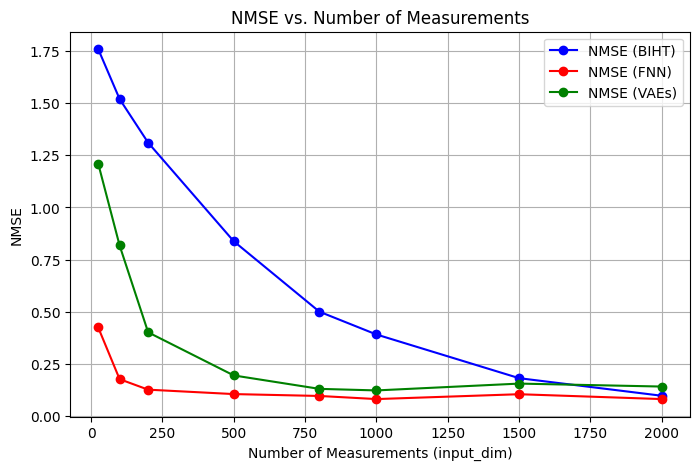

In [16]:
plt.figure(figsize=(8, 5))
plt.plot(measurements, mean_nmse_biht, marker='o', linestyle='-', color='b', label="NMSE (BIHT)")
plt.plot(measurements, nmse_values_mlp, marker='o', linestyle='-', color='r', label="NMSE (FNN)")
plt.plot(measurements, nmse_vae_list, marker='o', linestyle='-', color='g', label="NMSE (VAEs)")
plt.xlabel("Number of Measurements (input_dim)")
plt.ylabel("NMSE")
plt.title("NMSE vs. Number of Measurements")
plt.grid(True)
plt.legend()
plt.show()